In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
data = pd.read_csv('../data/crc_raw/CRC_2.0-public_clinical_data/regimen_cancer_level_dataset.csv')
data.head()


,cohort,record_id,institution,ca_seq,regimen_number,regimen_number_within_cancer,redcap_ca_index,drugs_num,drugs_inst,drugs_firstinst,...,tt_pfs_i_and_m_g_yrs,ttnt_any_ca_status,ttnt_any_ca_days,ttnt_any_ca_mos,ttnt_any_ca_yrs,ttnt_ca_seq_status,ttnt_ca_seq_days,ttnt_ca_seq_mos,ttnt_ca_seq_yrs,release_version
0,CRC,GENIE-DFCI-000048,DFCI,0,1,1,Yes,2,At the internal/native institution only,NaN,...,NaN,0,273,8.980263,0.747433,0,273,8.980263,0.747433,2.0-public
1,CRC,GENIE-DFCI-000147,DFCI,0,1,1,Yes,1,At external institution only,NaN,...,NaN,1,181,5.953947,0.495551,1,181,5.953947,0.495551,2.0-public
2,CRC,GENIE-DFCI-000147,DFCI,0,2,2,Yes,2,At external institution only,NaN,...,NaN,1,275,9.046053,0.752909,1,275,9.046053,0.752909,2.0-public
3,CRC,GENIE-DFCI-000147,DFCI,0,3,3,Yes,4,At external institution only,NaN,...,0.594114,1,473,15.559211,1.295003,1,473,15.559211,1.295003,2.0-public
4,CRC,GENIE-DFCI-000147,DFCI,0,4,4,Yes,1,At the internal/native institution only,NaN,...,0.366872,1,282,9.276316,0.772074,1,282,9.276316,0.772074,2.0-public


In [3]:
keep = ['record_id', 'institution', 'regimen_drugs', 'os_g_status', 'pfs_i_g_status', 'tt_pfs_i_g_days', 'pfs_m_g_status', 'tt_pfs_m_g_days', 'pfs_i_and_m_g_status', 'tt_pfs_i_and_m_g_days', 'pfs_i_or_m_g_status', 'tt_pfs_i_or_m_g_days']
data = data[keep]
data.head()

,record_id,institution,regimen_drugs,os_g_status,pfs_i_g_status,tt_pfs_i_g_days,pfs_m_g_status,tt_pfs_m_g_days,pfs_i_and_m_g_status,tt_pfs_i_and_m_g_days,pfs_i_or_m_g_status,tt_pfs_i_or_m_g_days
0,GENIE-DFCI-000048,DFCI,"Fluorouracil, Leucovorin Calcium",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GENIE-DFCI-000147,DFCI,Capecitabine,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GENIE-DFCI-000147,DFCI,"Capecitabine, Oxaliplatin",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GENIE-DFCI-000147,DFCI,"Bevacizumab, Fluorouracil, Irinotecan Hydrochl...",1,1.0,217.0,1.0,193.0,1.0,217.0,1.0,193.0
4,GENIE-DFCI-000147,DFCI,Trifluridine and Tipiracil Hydrochloride,1,1.0,134.0,1.0,134.0,1.0,134.0,1.0,134.0


In [4]:
data['regimen_drugs'] = data['regimen_drugs'].str.lower()

In [5]:
data['regimen'] = np.NaN

data.loc[(data['regimen_drugs'].str.contains('Fluorouracil', case=False, na=False)) |
    (data['regimen_drugs'].str.contains('Oxaliplatin', case=False, na=False)) |
    (data['regimen_drugs'].str.contains('Capecitabine', case=False, na=False)) |
    ~(data['regimen_drugs'].str.contains('mab', case=False, na=False) | 
        data['regimen_drugs'].str.contains('ib', case=False, na=False) |
        data['regimen_drugs'].str.contains('nib', case=False, na=False) |
        data['regimen_drugs'].str.contains('investigational', case=False, na=False) |
        data['regimen_drugs'].str.contains('everoli', case=False, na=False) |
        data['regimen_drugs'].str.contains('iri', case=False, na=False)), 'regimen'] = 'FOLFOX'
data.loc[(data['regimen_drugs'].str.contains('bevacizumab', case=False, na=False)), 'regimen'] = 'VEGF'
data.loc[(data['regimen_drugs'].str.contains('cetuximab', case=False, na=False)) | (data['regimen'].str.contains('panitu', case=False, na=False)), 'regimen'] = 'EGFR'
data.loc[(data['regimen_drugs'].str.contains('regorafenib', case=False, na=False)), 'regimen'] = 'Regorafenib'
data['regimen'].value_counts(dropna=False)


regimen
FOLFOX         2964
VEGF           1503
NaN             599
EGFR            243
Regorafenib     108
Name: count, dtype: int64

In [6]:
pfs_dict = {}
for i in ['pfs_i_g_status', 'pfs_m_g_status', 'pfs_i_and_m_g_status', 'pfs_i_or_m_g_status']:
    pfs_dict[i] = 'tt_' + i.split('status')[0] + 'days'
pfs_dict

{'pfs_i_g_status': 'tt_pfs_i_g_days',
 'pfs_m_g_status': 'tt_pfs_m_g_days',
 'pfs_i_and_m_g_status': 'tt_pfs_i_and_m_g_days',
 'pfs_i_or_m_g_status': 'tt_pfs_i_or_m_g_days'}

In [7]:
#get a list of time thresholds, 1-1825 days
time_thresh = [i for i in range(1, 1825)]

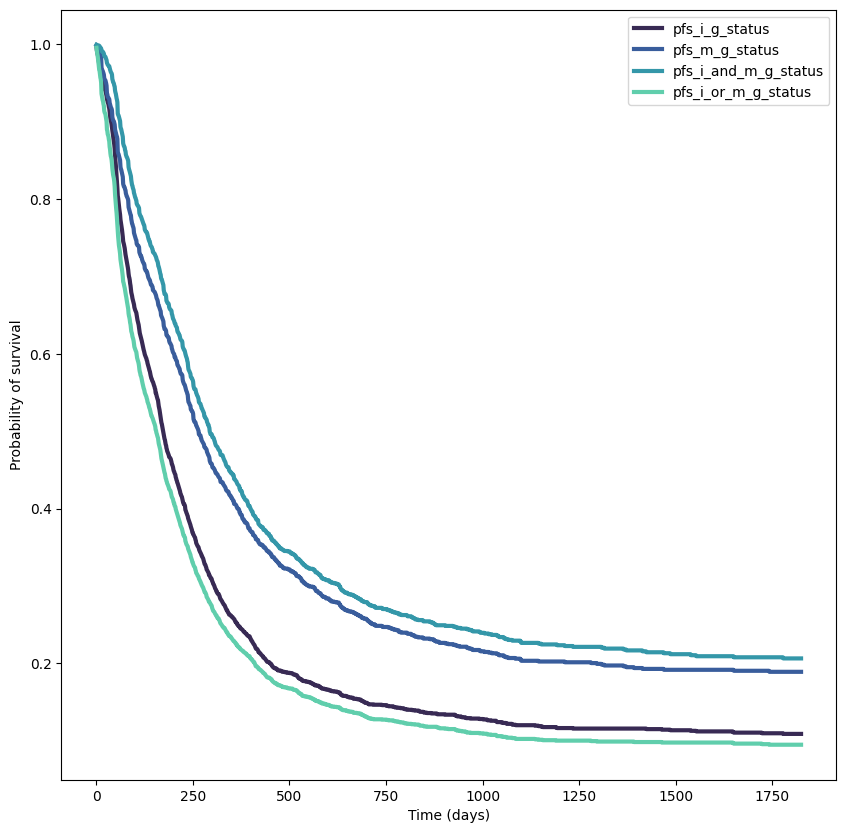

In [8]:
data_pfs = {}
km_pfs = {}
for stage in pfs_dict.keys():
    data_pfs[stage] = data.dropna(subset=[pfs_dict[stage]]).copy()
    km_pfs[stage] = pd.DataFrame(columns=['time', 'n_patients', 'n_prog', 'prob_pfs'])
    n_patients = data_pfs[stage].shape[0]
    prob_survival = 1
    for t in time_thresh:
        n_patients = n_patients - data_pfs[stage][(data_pfs[stage][pfs_dict[stage]] == t) & (data_pfs[stage][stage] == 0)].shape[0]
        n_died = data_pfs[stage][(data_pfs[stage][pfs_dict[stage]] == t) & (data_pfs[stage][stage] == 1)].shape[0]
        try:
            prob_survival = prob_survival * (1 - n_died/n_patients)
        except:
            prob_survival = 0
        try:
            perc_died = n_died/n_patients
        except:
            perc_died = 0
        km_pfs[stage] = pd.concat([km_pfs[stage], pd.DataFrame([[t, n_patients, n_died, prob_survival]], columns=['time', 'n_patients', 'n_prog', 'prob_pfs'])], axis=0)
        n_patients = n_patients - n_died
import seaborn as sns
cmap = sns.color_palette('mako', n_colors=len(km_pfs.keys()))
colors = {}
for i in km_pfs.keys():
    colors[i] = cmap[list(km_pfs.keys()).index(i)]
#plot the survival curves for the overall population and each stage on the same plot
plt.figure(figsize=(10,10))

for stage in km_pfs.keys():
    #make the lines thicker
    plt.plot(km_pfs[stage]['time'], km_pfs[stage]['prob_pfs'], label=stage, color=colors[stage], linewidth=3)
plt.xlabel('Time (days)')
plt.ylabel('Probability of survival')
plt.legend()
plt.rcParams.update({'font.size': 20})
plt.savefig('../results/figures/km_pfs_types.png', dpi=300, bbox_inches='tight')

In [9]:
pfs_dict = {}
for i in ['pfs_i_g_status', 'pfs_m_g_status', 'pfs_i_and_m_g_status', 'pfs_i_or_m_g_status']:
    pfs_dict[i] = 'tt_' + i.split('status')[0] + 'days'
pfs_dict

{'pfs_i_g_status': 'tt_pfs_i_g_days',
 'pfs_m_g_status': 'tt_pfs_m_g_days',
 'pfs_i_and_m_g_status': 'tt_pfs_i_and_m_g_days',
 'pfs_i_or_m_g_status': 'tt_pfs_i_or_m_g_days'}

In [10]:
reg_list = ['FOLFOX', 'VEGF', 'EGFR', 'Regorafenib']

In [11]:
for stage in reg_list:
    data_pfs[stage] = data[data['regimen'] == stage]
    data_pfs[stage].loc[data_pfs[stage]['tt_pfs_m_g_days'] > 1000, 'tt_pfs_m_g_days'] = 1000
    

In [12]:
data_pfs[stage]['tt_pfs_m_g_days'].describe()

count    104.000000
mean      93.067308
std      108.262560
min        0.000000
25%       38.750000
50%       69.000000
75%       99.250000
max      639.000000
Name: tt_pfs_m_g_days, dtype: float64

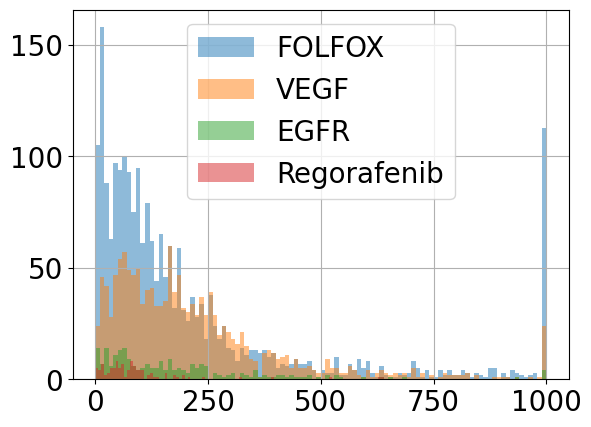

In [18]:
for stage in reg_list:
    data_pfs[stage] = data[data['regimen'] == stage]
    data_pfs[stage].loc[data_pfs[stage]['tt_pfs_m_g_days'] > 1000, 'tt_pfs_m_g_days'] = 1000
    #plot the histogram of the time to progression for each stage and make a legend
    data_pfs[stage]['tt_pfs_m_g_days'].hist(bins=100, alpha=0.5, label=stage)
    plt.legend()
plt.show()
    

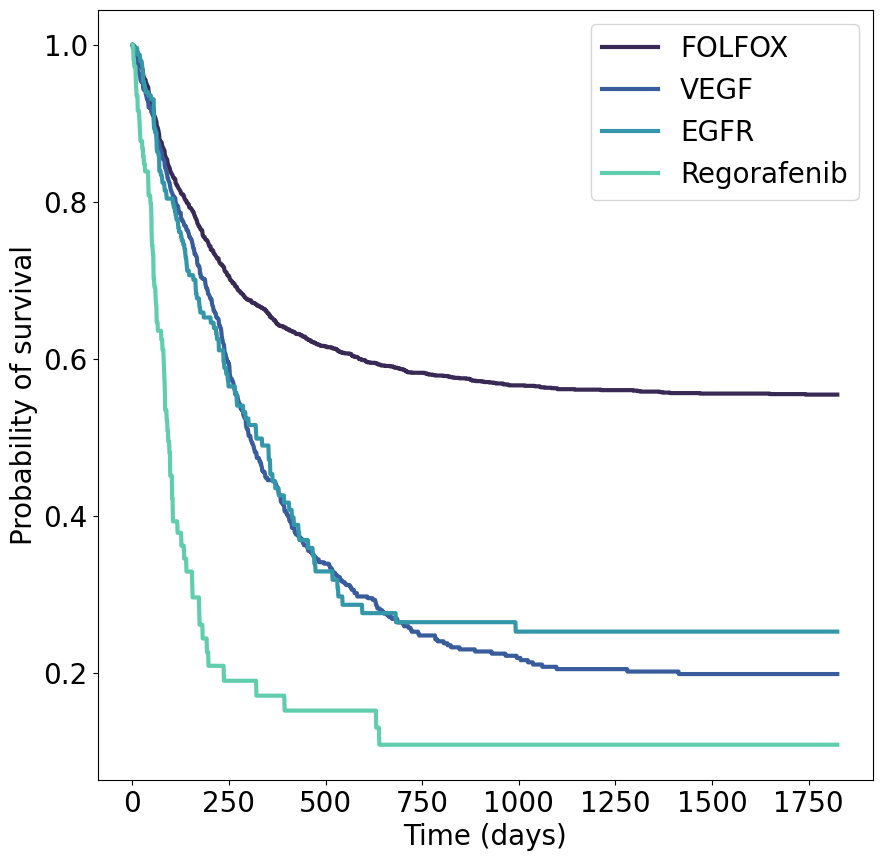

In [12]:
data_pfs = {}
km_pfs = {}
for stage in reg_list:
    data_pfs[stage] = data[data['regimen'] == stage]
    km_pfs[stage] = pd.DataFrame(columns=['time', 'n_patients', 'n_prog', 'prob_pfs'])
    n_patients = data_pfs[stage].shape[0]
    prob_survival = 1
    for t in time_thresh:
        n_patients = n_patients - data_pfs[stage].loc[(data_pfs[stage]['tt_pfs_m_g_days'] == t) & (data_pfs[stage]['pfs_m_g_status'] == 0)].shape[0]
        n_died = data_pfs[stage].loc[(data_pfs[stage]['tt_pfs_m_g_days'] == t) & (data_pfs[stage]['pfs_m_g_status'] == 1)].shape[0]
        try:
            prob_survival = prob_survival * (1 - n_died/n_patients)
        except:
            prob_survival = 0
        try:
            perc_died = n_died/n_patients
        except:
            perc_died = 0
        km_pfs[stage] = pd.concat([km_pfs[stage], pd.DataFrame([[t, n_patients, n_died, prob_survival]], columns=['time', 'n_patients', 'n_prog', 'prob_pfs'])], axis=0)
        n_patients = n_patients - n_died
import seaborn as sns
cmap = sns.color_palette('mako', n_colors=len(km_pfs.keys()))
colors = {}
for i in km_pfs.keys():
    colors[i] = cmap[list(km_pfs.keys()).index(i)]
#plot the survival curves for the overall population and each stage on the same plot
plt.figure(figsize=(10,10))

for stage in km_pfs.keys():
    #make the lines thicker
    plt.plot(km_pfs[stage]['time'], km_pfs[stage]['prob_pfs'], label=stage, color=colors[stage], linewidth=3)
plt.xlabel('Time (days)')
plt.ylabel('Probability of survival')
plt.legend()
plt.rcParams.update({'font.size': 20})
plt.savefig('../results/figures/km_pfs_drugs.png', dpi=300, bbox_inches='tight')

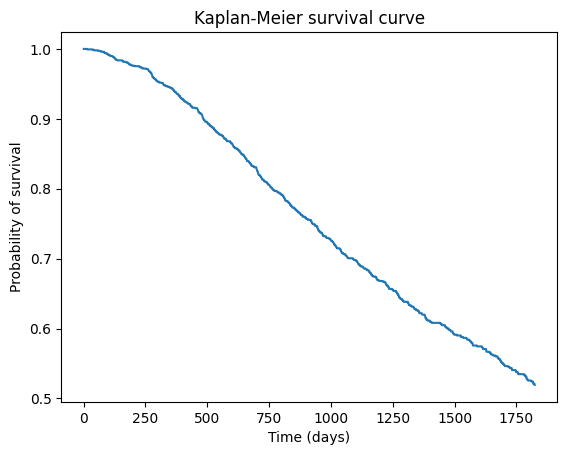

In [10]:
#plot the results
plt.plot(km_1['time'], km_1['prob_survival'])
plt.xlabel('Time (days)')
plt.ylabel('Probability of survival')
plt.title('Kaplan-Meier survival curve')
plt.show()

In [11]:
data['pred_prob_quart'].value_counts(dropna=False)

pred_prob_quart
NaN    1351
1.0      35
2.0      34
3.0      33
0.0      32
Name: count, dtype: int64

In [12]:
data = data.dropna(subset=['pred_prob_quart'])

In [13]:
pred_quart_values = [i for i in data['pred_prob_quart'].unique() if i not in ('Stage I-III NOS', np.NaN)]

In [14]:
data_stage = {}
km_stage = {}
for stage in pred_quart_values:
    data_stage[stage] = data[data['pred_prob_quart'] == stage]
    km_stage[stage] = pd.DataFrame(columns=['time', 'n_patients', 'n_died', 'prob_survival'])
    n_patients = data_stage[stage].shape[0]
    prob_survival = 1
    for t in time_thresh:
        n_patients = n_patients - data_stage[stage][(data_stage[stage]['OS_time'] == t) & (data_stage[stage]['OS'] == 0)].shape[0]
        n_died = data_stage[stage][(data_stage[stage]['OS_time'] == t) & (data_stage[stage]['OS'] == 1)].shape[0]
        try:
            prob_survival = prob_survival * (1 - n_died/n_patients)
        except:
            prob_survival = 0
        try:
            perc_died = n_died/n_patients
        except:
            perc_died = 0
        km_stage[stage] = pd.concat([km_stage[stage], pd.DataFrame([[t, n_patients, n_died, prob_survival]], columns=['time', 'n_patients', 'n_died', 'prob_survival'])], axis=0)
        n_patients = n_patients - n_died

In [15]:
import seaborn as sns
cmap = sns.color_palette('mako', n_colors=4)
colors = {0.0: cmap[0], 1.0: cmap[1], 2.0: cmap[2], 3.0: cmap[3]}

In [16]:
km_stage.keys()

dict_keys([1.0, 3.0, 2.0, 0.0])

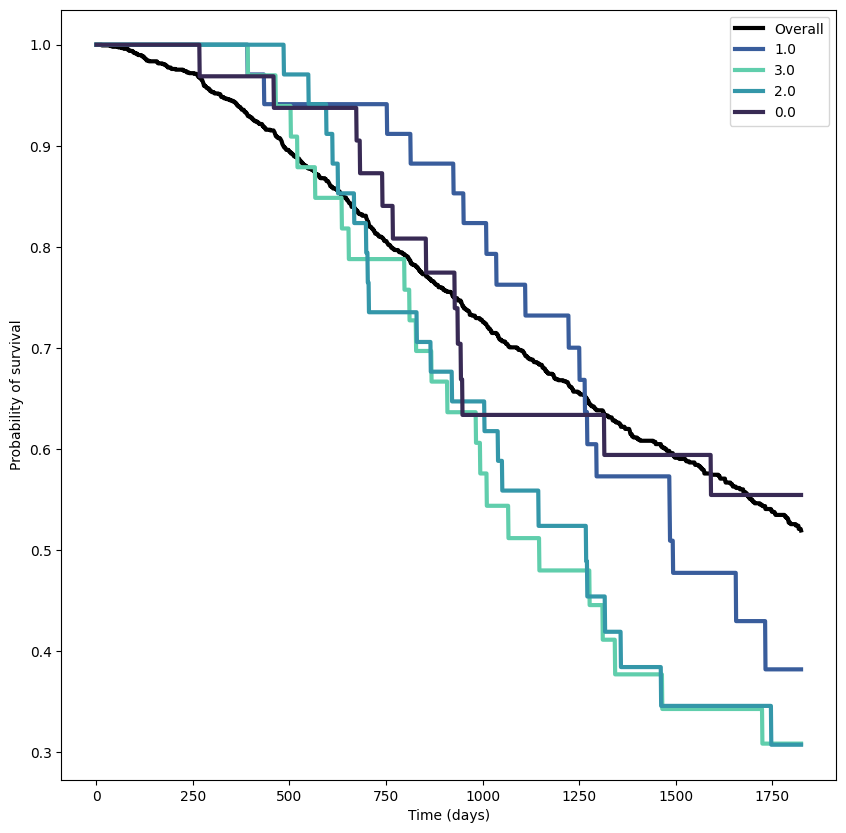

In [17]:
#plot the survival curves for the overall population and each stage on the same plot
plt.figure(figsize=(10,10))
plt.plot(km_1['time'], km_1['prob_survival'], label='Overall', color='black', linewidth=3)
for stage in km_stage.keys():
    #make the lines thicker
    plt.plot(km_stage[stage]['time'], km_stage[stage]['prob_survival'], label=stage, color=colors[stage], linewidth=3)
plt.xlabel('Time (days)')
plt.ylabel('Probability of survival')
plt.legend()
plt.rcParams.update({'font.size': 20})
plt.savefig('../results/figures/km.png', dpi=300, bbox_inches='tight')